# Building a Handwritten Digits Classifier

**What the project is about:** In this project, I'll build models that can classify handwritten digits. Before the year 2000, institutions like the United States Post Office used handwriting recognition software to read addresses, zip codes, and more. One of their approaches, which consists of pre-processing handwritten images then feeding to a neural network model is detailed in [this paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.852.5499&rep=rep1&type=pdf).

**Goal of this project:** My goal is to explore the effectiveness of deep, feedforward neural networks at classifying images.

## Working with Image Data

I'll start by importing the `load_digits()` [function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html), which returns a copy of the [hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) from UCI.

From there, I'll need to visualize an image from the dataframe by reshaping its pixel values back to its original dimensions (28 x 28 pixels) and plot them on a coordinate grid.

In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

digits_data = load_digits()

In [2]:
digits_data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
labels = pd.Series(digits_data['target'])

In [4]:
data = pd.DataFrame(digits_data['data'])
data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0


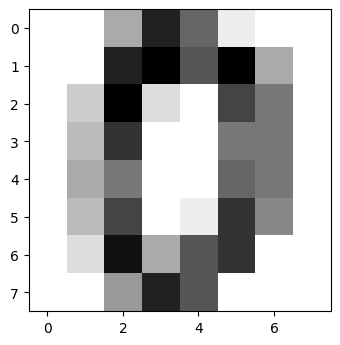

In [5]:
first_image = data.iloc[0]
np_image = first_image.values
np_image = np_image.reshape(8,8)

plt.imshow(np_image, cmap='gray_r')

Let's see a few more visualizations of images in the dataset.

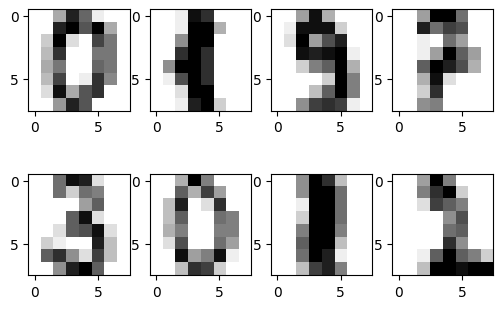

In [6]:
f, axarr = plt.subplots(2, 4)

axarr[0, 0].imshow(data.iloc[0].values.reshape(8,8), cmap='gray_r')
axarr[0, 1].imshow(data.iloc[99].values.reshape(8,8), cmap='gray_r')
axarr[0, 2].imshow(data.iloc[199].values.reshape(8,8), cmap='gray_r')
axarr[0, 3].imshow(data.iloc[299].values.reshape(8,8), cmap='gray_r')

axarr[1, 0].imshow(data.iloc[999].values.reshape(8,8), cmap='gray_r')
axarr[1, 1].imshow(data.iloc[1099].values.reshape(8,8), cmap='gray_r')
axarr[1, 2].imshow(data.iloc[1199].values.reshape(8,8), cmap='gray_r')
axarr[1, 3].imshow(data.iloc[1299].values.reshape(8,8), cmap='gray_r')

## K-Nearest Neighbors Model

While linear and logistic regression models make assumptions about the linearity between the features and the output labels, the k-nearest neighbors algorithm make no such assumption. This allows them to capture nonlinearity in the data. 

The k-nearest neighbors algorithm compares every unseen observation in the test set to all (or many, as some implementations constrain the search space) training observations to look for similar (or the "nearest") observations. Then, the algorithm finds the label with the most nearby observations and assigns that as the prediction for the unseen observation.

Below, I'll split up the data into train and test sets. From there, I can set up a pipeline for testing and training k-nn models.

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

# 50% Train / test validation
def train_knn(nneighbors, train_features, train_labels):
    knn = KNeighborsClassifier(n_neighbors = nneighbors)
    knn.fit(train_features, train_labels)
    return knn

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate(k):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train_knn(k, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies
        
knn_one_accuracies = cross_validate(1)
np.mean(knn_one_accuracies)

0.9888728037614452

Now, let's experiement with different values for k and plot the resulting classification accuracies.

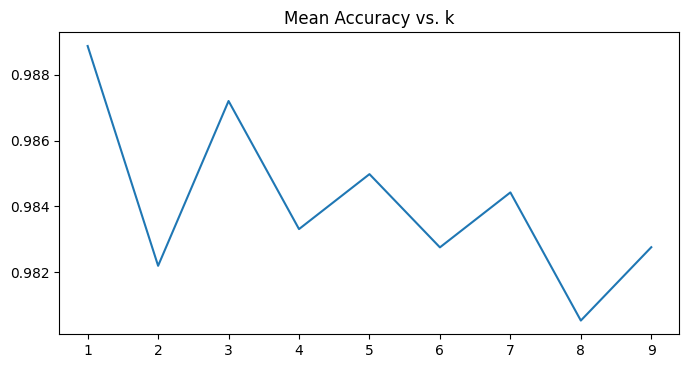

In [8]:
k_values = list(range(1,10))
k_overall_accuracies = []

for k in k_values:
    k_accuracies = cross_validate(k)
    k_mean_accuracy = np.mean(k_accuracies)
    k_overall_accuracies.append(k_mean_accuracy)
    
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. k")
plt.plot(k_values, k_overall_accuracies)

## Neural Network with One Hidden Layer

There are a few downsides to using k-nearest neighbors:

- high memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
- no model representation to debug and explore

So, why don't I try a neural network with a single hidden layer instead? To do this, I'll need to use the [MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) package from scikit-learn. Then, I'll utilize 4-fold cross validation to train and test a neural network model using a single hidden layer of x-number of neurons. This will allow me to rank the performance of the models by the overall accuracies and check for instances of overfitting.

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier

# 50% Train / test validation
def train_nn(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
       
        model = train_nn(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural

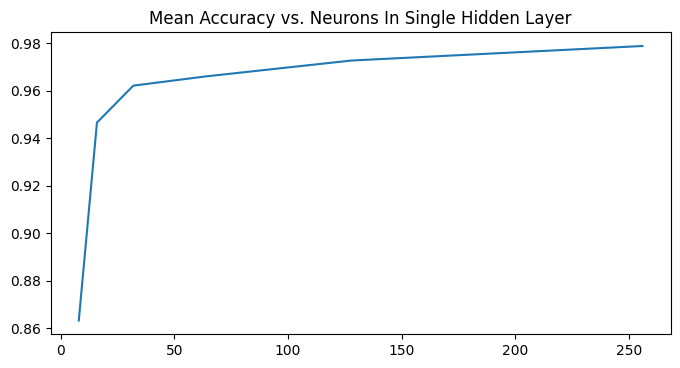

In [10]:
nn_one_neurons = [
    (8,),
    (16,),
    (32,),
    (64,),
    (128,),
    (256,)
]
nn_one_accuracies = []

for n in nn_one_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_one_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Single Hidden Layer")

x = [i[0] for i in nn_one_neurons]
plt.plot(x, nn_one_accuracies)

It looks like adding more neurons to the single hidden layer improved simple accuracy to approximately 97%. Simple accuracy computes the number of correct classifications the model made, but doesn't tell me anything about false or true positives or false or true negatives.

Given that k-nearest neighbors achieved approximately 98% accuracy, there doesn't seem to be any advantages to using a single hidden layer neural network for this problem.

## Neural Network with Two Hidden Layers

Adding more neurons to a single hidden layer vastly improved the classification accuracy, so next I'll try using two hidden layers and continue to increase the number of neurons in each layer.

To do this, I'll first modify  the neural network training pipeline to use 2 hidden layers instead in the network. Then, like before, I'll use 4-fold cross validation to train a neural network model using 2 hidden layers and make observations about the overall performance and accuracies.

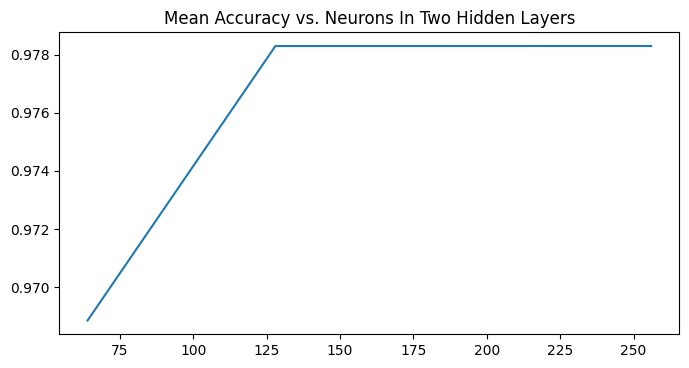

In [11]:
nn_two_neurons = [
    (64,64),
    (128, 128),
    (256, 256)
]
nn_two_accuracies = []

for n in nn_two_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_two_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Two Hidden Layers")

x = [i[0] for i in nn_two_neurons]
plt.plot(x, nn_two_accuracies)

In [12]:
nn_two_accuracies

[0.9688468200940361, 0.978301163078446, 0.9783024003959416]

Using 2 hidden layers improved my simple accuracy to 98%. While I'd traditionally be worried about overfitting, using 4-fold cross validation also gives me a bit more assurance that the model is generalizing to achieve the extra 1% in simple accuracy over the single hidden layer networks I tried earlier.

## Neural Network With Three Hidden Layers

Using more hidden layers is known to increase the amount of overfitting that happens. To help prevent overfitting, I'll increase the number of folds I use for k-fold cross validation to 6 while testing networks with 3 hidden layers.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

# 50% Train / test validation
def train_nn(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate_six(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 6, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
       
        model = train_nn(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural

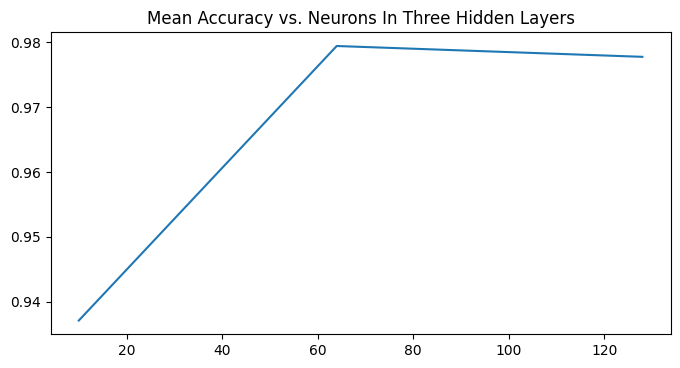

In [14]:
nn_three_neurons = [
    (10, 10, 10),
    (64, 64, 64),
    (128, 128, 128)
]

nn_three_accuracies = []

for n in nn_three_neurons:
    nn_accuracies = cross_validate_six(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_three_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Three Hidden Layers")

x = [i[0] for i in nn_three_neurons]
plt.plot(x, nn_three_accuracies)

In [15]:
nn_three_accuracies

[0.9371125975473803, 0.9794165737644, 0.9777480490523969]

Using 3 hidden layers returned a simple accuracy of nearly 98%, even with 6-fold cross validation.